In [1]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import warnings 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA

Using TensorFlow backend.


## Load data

In [2]:
data = pd.read_csv("s3://ai-diennea/data/export_wonkit_20210630102441.csv.gz")
# add the day of the week column
day_of_week = []
for i in range(len(data)):
    day_of_week.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M').day_name())
data['day_of_week'] = pd.DataFrame(day_of_week)

df = pd.read_csv("s3://ai-diennea/data/df.csv")
df = df.drop(['Unnamed: 0'], axis=1)
X = pd.read_csv("s3://ai-diennea/data/X.csv")
X = X.drop(['Unnamed: 0'], axis=1)
y = pd.read_csv("s3://ai-diennea/data/y.csv")
y = y.drop(['Unnamed: 0'], axis=1)
# train set
df_train, df_test = train_test_split(df, test_size=0.30, random_state=2)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
# test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=2)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
sent_open_hour_range = 36
open_click_hour_range = 24

def exp_decay_fit(x, sent_open_hour_range):
    if x > sent_open_hour_range*60:
        return .0
    if x < 0:
        return 1
    return math.exp(((-math.log(2)/(sent_open_hour_range*60))*x) + math.log(2))-1

def get_all_indexes(hash_mex, hash_contact, data):
    return data.index[(data['HashMessaggio'] == hash_mex) & (data['HashContatto'] == hash_contact)]

def from_min_to_hour_and_min(mins):
    hours = int(round(mins)) // 60
    minutes = int(round(mins)) % 60
    return "{}:{}".format(hours, minutes)

def evaluate(df, X, data, sent_open_hour_range, preds):  
    # from [0, 1] to mins
    for i in range(len(preds)):
        preds[i] *= 24*60 # this 24*60 is requierd to convert mins from [0, 1] into real mins
    
    # dict that contains for each contact, its messages
    dk = {}
    for cont in df['HashContatto'].unique():
        if cont not in dk:
            dk[cont] = {'HashMessaggio': []}
    # for each contact, I append its messages to compute fitSA subsequently
    for i in range(len(df)):
        dk[df['HashContatto'][i]]['HashMessaggio'].append(df['HashMessaggio'][i])

    curr = 0
    # get fitSA using the predicted sent
    fitSA_preds = []                                   
    for cont in dk:
        for mex in dk[cont]['HashMessaggio']:
            fitSA_preds.append(compute_fitSA_evaluation(mex, cont, sent_open_hour_range, data, preds[curr]))
            curr += 1
    total_mex = len(fitSA_preds)
    predicted_sent_better_than_usual_sent = 0
    predicted_sent_equal_usual_sent = 0
    predicted_sent_worst_usual_sent = 0
    for i in range(total_mex):
        if fitSA_preds[i] > X.iloc[i, 97]: # new postion of fitSA 97
            predicted_sent_better_than_usual_sent += 1
        elif fitSA_preds[i] == X.iloc[i, 97]: # new postion of fitSA 97
            predicted_sent_equal_usual_sent += 1
        else:
            predicted_sent_worst_usual_sent += 1
    return predicted_sent_better_than_usual_sent/total_mex, predicted_sent_equal_usual_sent/total_mex, predicted_sent_worst_usual_sent/total_mex

def compute_fitSA_evaluation(hash_mex, hash_contact, sent_open_hour_range, data, sent_pred):
    opens, clicks = [], []
    sent_pred = from_min_to_hour_and_min(sent_pred)
    list_index = get_all_indexes(hash_mex, hash_contact, data)
    for i in list_index:
        if data['EVENT.TYPE'][i] == 'Open':
            opens.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
        elif data['EVENT.TYPE'][i] == 'Click':
            clicks.append(pd.to_datetime(data["EVENT.DATE"][i], format='%Y/%m/%d %H:%M'))
    oldest = None
    if opens != []:
        for i in opens:
            if oldest is None:
                oldest = i
            elif i < oldest:
                oldest = i
    elif clicks != []:
        for i in clicks:
            if oldest is None:
                oldest = i
            elif i < oldest:
                oldest = i
    else: # this means that the mail has never been opened/clicked
        return .0
    oldest = str(oldest.hour) +":"+ str(oldest.minute)
    oldest = pd.to_datetime(oldest, format='%H:%M')
    sent_pred = pd.to_datetime(sent_pred, format='%H:%M')
    # compute minutes of the distance between sent-open/sent-click
    mins = ((oldest - sent_pred).days*24*60) + ((oldest - sent_pred).seconds//3600)*60 + ((oldest - sent_pred).seconds//60)%60
    return exp_decay_fit(mins, sent_open_hour_range)

## Linear Regression

In [46]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [47]:
preds = model.predict(X_test)
p = []
for i in range(len(preds)):
    p.append(preds[i][0])
evaluate(df_test, X_test, data, sent_open_hour_range, p)

(0.23435494635248216, 0.7002926228245803, 0.06535243082293753)

## Decison Tree

In [11]:
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

DecisionTreeRegressor()

In [216]:
preds = model.predict(X_test)
evaluate(df_test, X_test, data, sent_open_hour_range, preds)

(0.2307099953796396, 0.7494737922891319, 0.019816212331228503)

## Random Forest

In [18]:
model = RandomForestRegressor(max_depth=2)
model.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(max_depth=2)

In [214]:
preds = model.predict(X_test)
evaluate(df_test, X_test, data, sent_open_hour_range, preds)

(0.2307099953796396, 0.7497304789773602, 0.019559525643000154)

## Gradient Boosting

In [ ]:
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

In [ ]:
preds = model.predict(X_test)
evaluate(df_test, X_test, data, sent_open_hour_range, preds)

## Neural Networks

In [21]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12672     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 177,537
Trainable params: 177,537
Non-trainable params: 0
_________________________________________________________________


In [22]:
NN_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split = 0.2)

Train on 36359 samples, validate on 9090 samples
Epoch 1/10
36359/36359 [==============================] - 6s 167us/step - loss: 0.0671 - mean_absolute_error: 0.0671 - val_loss: 0.0643 - val_mean_absolute_error: 0.0643
Epoch 2/10
36359/36359 [==============================] - 5s 141us/step - loss: 0.0621 - mean_absolute_error: 0.0621 - val_loss: 0.0624 - val_mean_absolute_error: 0.0624
Epoch 3/10
36359/36359 [==============================] - 5s 141us/step - loss: 0.0617 - mean_absolute_error: 0.0617 - val_loss: 0.0605 - val_mean_absolute_error: 0.0605
Epoch 4/10
36359/36359 [==============================] - 5s 141us/step - loss: 0.0616 - mean_absolute_error: 0.0616 - val_loss: 0.0600 - val_mean_absolute_error: 0.0600
Epoch 5/10
36359/36359 [==============================] - 5s 141us/step - loss: 0.0614 - mean_absolute_error: 0.0614 - val_loss: 0.0608 - val_mean_absolute_error: 0.0608
Epoch 6/10
36359/36359 [==============================] - 5s 141us/step - loss: 0.0613 - mean_absolut

In [65]:
preds = NN_model.predict(X_test)
p = []
for i in range(len(preds)):
    p.append(preds[i][0])
evaluate(df_test, X_test, data, sent_open_hour_range, p)

### Create new X with only features that contributes

In [36]:
X.drop(X.columns.difference(X.columns[np.where(model.feature_importances_ > 0)]), axis=1, inplace=True)

In [34]:
onlyf

Index(['OR 5-6', 'OR 9-10', 'OR 11-12', 'OR 12-13', 'OR 16-17', 'OR 17-18',
       'OR 20-21', 'CR 15-16', 'CR 17-18', 'CR 20-21', 'OR-C 6-7',
       'OR-C 16-17', 'OR-C 17-18', 'OR-C 18-19', 'OR-C 22-23', 'CR-C 3-4',
       'CR-C 6-7', 'CR-C 16-17', 'fitSA'],
      dtype='object')

In [38]:
# train set
df_train, df_test = train_test_split(df, test_size=0.30, random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
# test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [39]:
model = RandomForestRegressor(max_depth=2)
model.fit(X_train, y_train)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(max_depth=2)

In [44]:
preds = model.predict(X_test)
evaluate(df_test, X_test, data, sent_open_hour_range, preds)

(0.21115046973663945, 0.5996714410390677, 0.18917808922429283)

**Conclusion**: removing only the top features that contributes results in a dramatic loss of performance

## PCA

In [54]:
pca = PCA(n_components=3)
pca.fit(X_train)
X_pca_train = pca.transform(X_train)

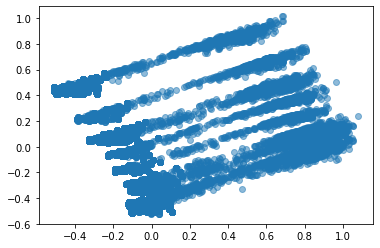

In [55]:
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], alpha=0.5)
plt.show()

In [56]:
model = RandomForestRegressor(max_depth=2)
model.fit(X_pca_train, y_train)

/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


RandomForestRegressor(max_depth=2)

In [57]:
pca = PCA(n_components=3)
pca.fit(X_test)
X_pca_test = pca.transform(X_test)

In [58]:
preds = model.predict(X_pca_test)

In [59]:
evaluate(df_test, X_test, data, sent_open_hour_range, preds)

(0.23435494635248216, 0.7002926228245803, 0.06535243082293753)

**Conclusion**: with pca there is an increment of when I do better but a slighlty decrease of when I do worse.

## Regression with CNNs

In [76]:
from PIL import Image
import os, glob, sys, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.layers import Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras import losses
from keras import backend as K 
import matplotlib.pyplot as plt
import math
from keras.optimizers import SGD, Adam
from keras import metrics
from keras import models, layers, optimizers 

In [ ]:
droprate=0.25

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=(9,9,1), activation="relu")) 
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(droprate))

model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(droprate))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(1))

In [45]:
arr = np.array([])
for i in range(len(X_train)):
    row = X_train.iloc[i, :].to_numpy().reshape(-1, 1)[17:, :].reshape(9, 9, 1)
    arr = np.append(arr, row)

In [66]:
X_train_img = arr.reshape(X_train.shape[0], 9, 9, 1)

In [67]:
model.fit(X_train_img, y_train, batch_size=32, epochs=3, validation_split=0.2)

Train on 36359 samples, validate on 9090 samples
Epoch 1/3
36359/36359 [==============================] - 29s 809us/step - loss: 0.1016 - rmsle: nan - val_loss: 0.0091 - val_rmsle: 0.1799
Epoch 2/3
36359/36359 [==============================] - 25s 689us/step - loss: 0.0125 - rmsle: nan - val_loss: 0.0074 - val_rmsle: 0.1601
Epoch 3/3
36359/36359 [==============================] - 25s 680us/step - loss: 0.0096 - rmsle: 0.1824 - val_loss: 0.0084 - val_rmsle: 0.1714


In [ ]:
def rmsle(y_test, y_pred):
    return K.sqrt(K.mean(K.square(K.log(y_pred) - K.log(y_test))))

model.compile(loss= 'mean_squared_error', optimizer='adam', metrics=[rmsle])
model.summary()
model.fit(x_train, y_train, batch_size=32, epochs=3, validation_split=0.2)

In [70]:
arr_test = np.array([])
for i in range(len(X_test)):
    row = X_test.iloc[i, :].to_numpy().reshape(-1, 1)[17:, :].reshape(9, 9, 1) # TODO: discard the feature that contributes 0
    arr_test = np.append(arr_test, row)

In [71]:
X_test_img = arr_test.reshape(X_test.shape[0], 9, 9, 1)

In [72]:
X_test_img.shape

(19479, 9, 9, 1)

In [73]:
preds = model.predict(X_test_img)

In [74]:
preds

array([[0.51915395],
       [0.5132235 ],
       [0.46839494],
       ...,
       [0.581542  ],
       [0.5659067 ],
       [0.51322347]], dtype=float32)

In [75]:
p = []
for i in range(len(preds)):
    p.append(preds[i][0])
evaluate(df_test, X_test, data, sent_open_hour_range, p)

(0.23142871810667898, 0.7475229734585964, 0.021048308434724574)

In [ ]:
# TODO: try to add in the dataset the day of the week and see if its better